# Planning in Elevator Environment

This notebook describes details of the Elevator environment. You can use this notebook as a reference and tutorial for your assignmentmm

# Introduction
The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators. Potential passengers arrive at a floor according to the Poisson process, with specific rates that can be different across different floors. An elevator can move upwards to pick up passengers; once it opens its door to let people in, it can only move down towards the bottom floor, though the elevator can stop at intermediate floors to pick up more passengers.

Per each person in an elevator, there is a small penalty in rewards. Additionally, there is a penalty for each person waiting for an elevator.
When an elevator delivers a passenger to their destination, a large positive reward is given per person. So, a good policy should be able to minimize the penalties while maximizing the positive rewards by delivering many people so that they can go back home!


# States
The state space represents number of people waiting and inside the elevators including elevator state as following:

State | Type | Desc | Math notation
--- | --- | --- | ---
num-person-waiting(floor) | int | Number of people waiting on a floor | $N^{(f)}_p$
num-person-in-elevator(elevator) | int | Number of people in an elevator | $N^{(e)}_p$
elevator-dir-up(elevator)  | bool | Direction of an elevator (True if going up) | $N^{(e)}_d$
elevator-closed(elevator) |	bool |	Whether the door is open or closed | $N^{(e)}_c$
elevator-at-floor(elevator,floor) | bool | 	Whether an elevator is on a specific floor | $N^{(e)}_l$

# Actions

There are 6 actions related to elevator control:

Actiom | Type | Desc
--- | --- | ---
move-current-dir(elevator) |	Discrete(2) |	Whether to move in the current direction (cannot move if door is open)
open-door(elevator) |	Discrete(2) |	Whether to open the door to let people in (direction changes to down afterwards)
close-door(elevator) |	Discrete(2) |	Whether to close door

``Discrete`` referes to [gym space type](https://www.gymlibrary.dev/api/spaces/#gym.spaces.Discrete).
# Reward

The reward for the environment defined as:

$r_t = - p_e * \sum_{e \in elevators} N^{(e)}_p - p_w * \sum_{f \in floors} N^{(f)}_p + R_{del} * \sum_{e \in elevators} (N^{(e)} I_{bottom(e)})$

where
- $p_e$ is a penalty coefficient for people inside the elevator;
- $p_w$ is a penalty coefficient for people waiting in each floor;
- $R_{del}$ is a reward for delivering people to the bottom floor;

# Discretization

The Elevator environment has continious state space. We discretize all states to make that we can run algorithms that are taught in the class. The number of discrete state space is:

$$\text{Total Discrete States} = (N_{p_\text{max waiting}} + 1)^{N_f} * 2^{2N_e} * N_f^{N_e} * (N_{p_\text{max elevator}} + 1)^{N_e}$$

where $N_e$ is a number of elevators, $N_f$ is a number of floors, $N_{p_\text{max elevator}}$ is a number of maximum allowed people in the elevator, $N_{p_\text{max waiting}}$ is a number of maximum people to wait for the elevators at each floor.

# About RDDL

The Elevator environment is given in Relational Dynamic Influence Diagram Language (RDDL). Original implementation can be found [here](https://ataitler.github.io/IPPC2023/elevator.html). It also provides RDDL to Gym conversion package that can be easily used in our gym environment. We highly recommend to read through rddl specification for elevator environment to understand the environment better. Here we provide useful links to for that:
- RDDL language description; [Link](https://users.cecs.anu.edu.au/~ssanner/IPPC_2011/RDDL.pdf). There is no need to read all documentation in detail. It is recommended to use it as a reference to find definitions for building blocks within rddl domain
- Elevator Environment used in this Assignment; [Link](https://github.com/tasbolat1/pyRDDLGym/blob/main/pyRDDLGym/Examples/Elevators/domain.rddl). Please read through domain specificaiton carefull to understand the environment. If some of the blocks are not clear, you can find explanations in the above description link.

# Running in OpenAi Gym framework

Even though we follow OpenAi Gym structure, there are some differences due to the discretization process. We highlight them when it happens

In [ ]:
# Connect to Google drive to save your model, etc.,

from google.colab import drive
drive.mount('/content/drive')

# Installation and setup

The gym environment requires an older version numpy (and corresponding packages). <br>
The following cell contains the `requirements.txt` to setup the python environment used in the rest of this notebook.


In [12]:
%%writefile requirements.txt

cloudpickle==3.1.1
contourpy==1.3.0
cycler==0.12.1
filelock==3.18.0
fonttools==4.56.0
fsspec==2025.3.0
gym==0.26.2
gym-notices==0.0.8
importlib_metadata==8.6.1
importlib_resources==6.5.2
Jinja2==3.1.6
kiwisolver==1.4.7
MarkupSafe==3.0.2
matplotlib==3.9.4
mpmath==1.3.0
networkx==3.2.1
numpy==1.24.2
nvidia-cublas-cu12==12.4.5.8
nvidia-cuda-cupti-cu12==12.4.127
nvidia-cuda-nvrtc-cu12==12.4.127
nvidia-cuda-runtime-cu12==12.4.127
nvidia-cudnn-cu12==9.1.0.70
nvidia-cufft-cu12==11.2.1.3
nvidia-curand-cu12==10.3.5.147
nvidia-cusolver-cu12==11.6.1.9
nvidia-cusparse-cu12==12.3.1.170
nvidia-cusparselt-cu12==0.6.2
# nvidia-nccl-cu12==2.21.5
nvidia-nvjitlink-cu12==12.4.127
nvidia-nvtx-cu12==12.4.127
packaging==24.2
pillow==11.1.0
ply==3.11
pygame==2.6.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
six==1.17.0
sympy==1.13.1
torch==2.6.0
tqdm==4.67.1
# triton==3.2.0
zipp==3.21.0

Overwriting requirements.txt


Now install the requirements.

You may be asked to restart the session to load the installed versions of the packages. If so, restart the session and continue using the notebook

In [13]:
!pip install -r requirements.txt

  Using cached contourpy-1.3.0-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached importlib_metadata-8.6.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached matplotlib-3.9.4-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached numpy-1.24.2-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-wi

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


Install the pyRDDL gym environment using the given repository.

In [ ]:
!pip install -q git+https://github.com/tasbolat1/pyRDDLGym.git

  Preparing metadata (setup.py) ... done


In [10]:
from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
from IPython.display import Image # for displaying gifs in colab
import numpy as np # we use nympy to work with numbers, arrays and matrices
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

Initiate the Elevator environment. To have visualizer to work, set ``is_render`` to be ``True`` and specify directory where it saves

In [11]:
is_render = True
render_path = 'content/' # path to the folder on your google drive
env = Elevator(is_render=is_render, render_path=render_path, instance = 5)

d:\GitHub\cs4246_assignment_2\.venv\Lib\site-packages\pyRDDLGym\Examples d:\GitHub\cs4246_assignment_2\.venv\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with new languag

d:\GitHub\cs4246_assignment_2\.venv\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


The above environment is discrete both in terms of actions and observation space. One can access underlying original continous space environment through ``base env`` variable. Here we show how can actions and observation space can be accessed in discrete environment. We start with actions

In [12]:
print('Discrete environment actions:')
print(env.disc_actions)
print('Continious environment actions:')
print(env.base_env.action_space)

Discrete environment actions:
{0: ('e0_movcurdir_0',), 1: ('e0_movcurdir_1',), 2: ('e0_close_0',), 3: ('e0_close_1',), 4: ('e0_open_0',), 5: ('e0_open_1',)}
Continious environment actions:
Dict('move-current-dir___e0': Discrete(2), 'open-door___e0': Discrete(2), 'close-door___e0': Discrete(2))


As you can see, discrete actions are redefined differently. For example, action ``5`` means the elevator door opens.

The observation space for the discrete environment quite large, specificially:

In [13]:
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")

Observation space size for the discrete Elevator Environment: 225280


it is defined as an integer and can be easily accessed:

In [14]:
state = 1534
print(f'State {state} has a following description {env.disc_states[state]}')

State 1534 has a following description elevpeople0_0|elevfloor0_0|elevdir0_0|elevdoor0_1|f0_1|f1_3|f2_3|f3_3|f4_2|


The rest of the part for Discrete Elevator environment follows normal Gym settings.

In [15]:
current_state = env.reset(seed = 30)
print(f'Current environment state after restart: {current_state}')
random_action = np.random.randint(6)
next_state, reward, terminated, info = env.step(random_action)
print(f'State after taking random action {random_action}: {next_state}')


Current environment state after restart: 2048
State after taking random action 5: 2048


Here, we provide complete loop of policy for random agent

In [16]:
import PIL

is_render = True

# reset environment
state = env.reset(seed=40)

total_reward = 0
for t in range(env.horizon):

    # sample random action
    action = np.random.randint(6)

    # take an action
    next_state, reward, terminated, info = env.step(action)  # self.env.step(action)

    if is_render:
        env.render()

    total_reward += reward
    print()
    print(f'state      = {state}')
    print(f'action     = {action}')
    print(f'next state = {next_state}')
    print(f'reward     = {reward}')
    print(f'total_reward     = {total_reward}')
    state = next_state

env.close()


if is_render:
    env.save_render()
    img = PIL.Image.open(f'{render_path}/elevator.gif').convert('RGB')
    img.show()

d:\GitHub\cs4246_assignment_2\.venv\Lib\site-packages\pyRDDLGym\Visualizer\MovieGenerator.py:83: UserWarning: removed 1 temporary files at content/Elevators_*.png
  self.reset()



state      = 2048
action     = 3
next state = 2052
reward     = 0.0
total_reward     = 0.0

state      = 2052
action     = 0
next state = 2116
reward     = -3.0
total_reward     = -3.0

state      = 2116
action     = 0
next state = 2116
reward     = -6.0
total_reward     = -9.0

state      = 2116
action     = 5
next state = 2116
reward     = -6.0
total_reward     = -15.0

state      = 2116
action     = 5
next state = 2116
reward     = -6.0
total_reward     = -21.0

state      = 2116
action     = 2
next state = 2116
reward     = -6.0
total_reward     = -27.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -33.0

state      = 2116
action     = 3
next state = 2116
reward     = -6.0
total_reward     = -39.0

state      = 2116
action     = 3
next state = 2116
reward     = -6.0
total_reward     = -45.0

state      = 2116
action     = 0
next state = 2116
reward     = -6.0
total_reward     = -51.0

state      = 2116
action     = 0
next state = 2116
rew

d:\GitHub\cs4246_assignment_2\.venv\Lib\site-packages\pyRDDLGym\Visualizer\MovieGenerator.py:83: UserWarning: removed 201 temporary files at content/Elevators_*.png
  self.reset()


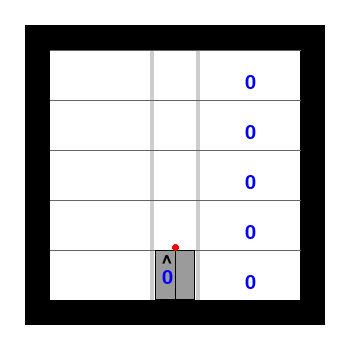

In [17]:
env.save_render()
Image('content/elevator.gif')

# References:
1. Original pyRDDL github repository. [Link](https://github.com/ataitler/pyRDDLGym)
2. IPPC 2023 Elevator Environment Description. [Link](https://ataitler.github.io/IPPC2023/elevator.html)
3. OpenAI Gym Framework. [Link](https://www.gymlibrary.dev/index.html)

FAQs:
1. *Do I need to know the details of original continuous Elevator environment:*
  - No, the assignment 2 is executed on discrete version of the environment. This tutorial notebook shall be sufficient to get started to code.
2. *Do I need to know OpenAI Gym Framework details before getting started:*
  - It is highly recommended to know syntax of OpenAI Gym Framework since we heavily use same structure for this assignment.
3. *Is it OK to receive negative reward even after finding good policy:*
  - Yes, it is totally fine. Imagine that at some point elevator opens the door at floor 3, and from this moment the negative reward accumulated for any persone wating at floor 4 since the elevator cannot go up once the door is open.